In [1]:
import sys

sys.path.append("../berries")


In [2]:
from my_datasets import Supervised1D, load_supervised_1d

n_samples, d_x, d_y, X, y, X_test, y_test = load_supervised_1d("mnist")

/home/owner/Projects/picojam/pico/.venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
X = X / 255.0
X_test = X_test / 255.0
n_samples_test = X_test.shape[0]

X = 2 * X - 1
X_test = 2 * X_test - 1

In [142]:
d_h_layer = 128
d_h = 256
n_g_layers = 8
n_d_layers = 4
d_in = d_x
# d_out = d_y
d_out = d_x
d_z = 64 

In [146]:

import importlib
import nn
importlib.reload(nn)
import pf
importlib.reload(pf)
from nn import mglu_net_config, mglu_net, rmglu_net
from pf import F, _
from optax import sigmoid_binary_cross_entropy

from jax.numpy import mean, exp, log, tanh, array
from jax.nn import sigmoid, log_sigmoid


# def gan_config(d_z, d_in, d_h_layer, d_h, n_g_layers, n_d_layers, init):
#     return {
#         "generator":mglu_net_config(d_z, d_h_layer, d_in, d_h, n_g_layers, init),
#         "discriminator": mglu_net_config(d_in, d_h_layer, 1, d_h, n_d_layers, init)
#     }



generator = F(mglu_net).swap() >> tanh
#discriminator = F(mglu_net).swap()
def discriminator(W, x):
    return mglu_net(x, W)


def generator_value_and_loss(Wg, Wd, z):
    X_gen = generator(Wg, z)
    return X_gen, -log_sigmoid(discriminator(Wd, X_gen))

def discriminator_loss_X(Wd, X_gen, X):
    return sigmoid_binary_cross_entropy(discriminator(Wd, X), array(1)) + sigmoid_binary_cross_entropy(discriminator(Wd, X_gen), array(0))


def discriminator_loss_z(W, X, z):
    X_gen = generator(W['generator'], z)
    return discriminator_loss_X(W['discriminator'], X_gen, X)


d_loss_X_bm = F(discriminator_loss_X).vmap((None, 0, 0), 0) >> mean

generator_b = generator.vmap((None, 0), 0)

def g_val_loss_bm(Wg, Wd, z):
    X_gen, loss = F(generator_value_and_loss).vmap((None, None, 0), 0)(Wg, Wd, z)
    return mean(loss), X_gen 

[[8.00067]] [[8.00067]] [[0.00033541]]
generator:
    mglu:
        tuple:
            sglu:
                wv:
                    array shape: (64, 256)
                wu:
                    array shape: (64, 256)
                wo:
                    array shape: (256, 128)
                total params: 65536
            rmsn:
                d:
                    128.0
                total params: 1
            total params: 65537
        tuple:
            sglu:
                wv:
                    array shape: (128, 256)
                wu:
                    array shape: (128, 256)
                wo:
                    array shape: (256, 128)
                total params: 98304
            rmsn:
                d:
                    128.0
                total params: 1
            total params: 98305
        tuple:
            sglu:
                wv:
                    array shape: (128, 256)
                wu:
                    array shape: (128, 256)
     

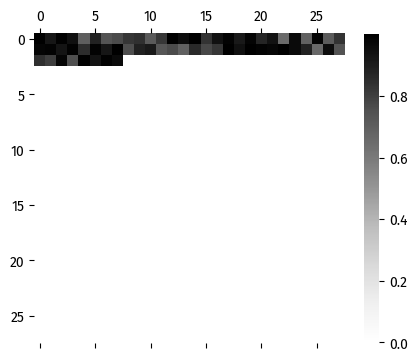

In [180]:
import optax
from jax import grad, jit, value_and_grad
from jax.tree_util import tree_map
import random_utils
import init_utils
from nn import init_weights, fmt_weights
from plot_utils import visualize_matrix

seed = 0
key_gen = random_utils.infinite_safe_keys(seed)


def get_noise(size, key):
    return init_utils.normal_init(key, sd=1., shape=size)

def get_noise_batch(batch_size): 
    return get_noise([batch_size, d_z], next(key_gen))



method = {"type": "zer0", "std": 0.001}
# method = {"type": "normal", "std": 0.01}
W = init_weights(next(key_gen), gan_config(d_z, d_in, d_h_layer, d_h, n_g_layers, n_d_layers, method, method))
d_loss0 = discriminator_loss_z(W,  X_test[0, :], get_noise_batch(1))
Xp0, g_loss0 = generator_value_and_loss(W['generator'], W['discriminator'], get_noise_batch(1))
visualize_matrix(Xp0.reshape(28, 28), dpi=100)
dx_loss0 = discriminator_loss_X(W['discriminator'], Xp0, X_test[0, :])

print(dx_loss0, d_loss0, g_loss0)
print(fmt_weights(W)[0])


In [194]:
import math, random

lr_d = 0.005
lr_g = 0.005
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
#opt = optax.masked(optax.rmsprop(lr), mask_fn)
opt_d = optax.masked(optax.adam(lr_d), mask_fn)
opt_g = optax.masked(optax.rmsprop(lr_g), mask_fn)
state_gen = opt_g.init(W["generator"])
state_disc = opt_d.init(W["discriminator"])
opt_states = {"generator": state_gen, "discriminator": state_disc}
@jit
def update(W, x, z, opt_states):
    (loss_g, xp), grad_g = value_and_grad(g_val_loss_bm, has_aux=True)(W['generator'], W['discriminator'], z)
    g_updates, opt_state_g = opt_g.update(grad_g, opt_states['generator'])
    wg = optax.apply_updates(W['generator'], g_updates)

    loss_d, grad_d = value_and_grad(d_loss_X_bm)(W['discriminator'], xp, x)
    d_updates, opt_state_d = opt_d.update(grad_d, opt_states['discriminator'])
    wd = optax.apply_updates(W['discriminator'], d_updates)

    return {"discriminator": wd, "generator": wg}, {"discriminator": opt_state_d, "generator": opt_state_g}, {"discriminator": loss_d, "generator": loss_g}


@jit
def update_g(W, x, z, g_opt_state):
    (loss_g, xp), grad_g = value_and_grad(g_val_loss_bm, has_aux=True)(W['generator'], W['discriminator'], z)
    g_updates, opt_state_g = opt_g.update(grad_g, g_opt_state)
    wg = optax.apply_updates(W['generator'], g_updates)
    return wg, opt_state_g, loss_g

def sample(batch_size):
    return X[random.sample(range(n_samples), batch_size), :]


W0, opt_states0, losses = update(W, sample(2), get_noise([2, d_z], next(key_gen)), opt_states)
print({k: v.item() for k, v in losses.items()})

{'discriminator': 2.827446721198612e-09, 'generator': 19.68389320373535}


In [195]:
import itertools
import matplotlib.pyplot as plt
from IPython import display

image_width, image_length, image_channels = 28, 28, 1
num_test_samples = 25 
size_figure_grid = int(math.sqrt(num_test_samples))

def display_samples(ax, image_matrix, num_samples=25):
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    # reshaped_generated_images = fake_images.view(batch_size, 28, 28)
    
    for k in range(num_test_samples):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i,j].cla()
        ax[i,j].imshow(image_matrix[k,:].reshape(image_width, image_length), cmap='Greys_r')
    
def show_samples(x):
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    display_samples(ax, x[:num_test_samples], num_samples=num_test_samples)
    display.clear_output(wait=True)
    display.display(fig)

In [197]:
from jax.numpy import ones_like, zeros_like
methodd = {"type": "zer0", "std": 0.001}
method = {"type": "normal", "std": 0.01}
def gan_config(d_z, d_in, d_h_layer, d_h, n_g_layers, n_d_layers, initd, initg):
    return {
        "generator":mglu_net_config(d_z, d_h_layer, d_in, d_h, n_g_layers, initd),
        "discriminator": mglu_net_config(d_in, d_h_layer, 1, d_h, n_d_layers, initg)
    }
W = init_weights(next(key_gen), gan_config(d_z, d_in, d_h_layer, d_h, n_g_layers, n_d_layers, method, method))


state_gen = opt_g.init(W["generator"])
state_disc = opt_d.init(W["discriminator"])
opt_states = {"generator": state_gen, "discriminator": state_disc}

def discriminator_loss_X(Wd, X_gen, X):
    return sigmoid_binary_cross_entropy(discriminator(Wd, X), array(1)) + sigmoid_binary_cross_entropy(discriminator(Wd, X_gen), array(0))

d_loss_x_bm = F(discriminator_loss_X).vmap((None, 0, 0), 0) >> mean

batch_size = 256
@jit
def update_d(wd, x, xp, d_opt_state):
    grad_d = grad(d_loss_x_bm)(wd, xp, x)
    d_updates, opt_state_d = opt_d.update(grad_d, d_opt_state)
    wd = optax.apply_updates(wd, d_updates)
    return wd, opt_state_d

def discriminator_accuracy(Wd, X_gen, X):
    gen = sigmoid(discriminator(Wd, X_gen))
    real = sigmoid(discriminator(Wd, X))
    return gen, real

discriminator_accuracy_b = F(discriminator_accuracy).vmap((None, 0, 0), 0)
discriminator_b = F(discriminator).vmap((None, 0), 0)


data = sample(batch_size)
z = get_noise_batch(batch_size)
xp = generator_b(W['generator'], z)
for i in range(50):
    if i % 10 == 0:
        W['discriminator'], opt_states['discriminator'] = update_d(W['discriminator'], data, xp, opt_states['discriminator'])
        acc = discriminator_accuracy_b(W['discriminator'], xp, data)
        loss = d_loss_X_bm(W['discriminator'], xp, data)
        print(f"loss {loss.item()}")
        print(f"gen {acc[0].mean().item()} real {acc[1].mean().item()}")

# for i in range(500):
#     W['generator'], opt_states['generator'], g_loss = update_g(W, data, get_noise_batch(batch_size), opt_states['generator'])
#     if i % 100 == 0:
#         print(f"g_loss {g_loss.item()}")

loss 1.3832619190216064
gen 0.49879002571105957 real 0.5003104209899902
loss 1.3601081371307373
gen 0.5869123935699463 real 0.624863862991333
loss 1.4204788208007812
gen 0.47215163707733154 real 0.45872440934181213
loss 1.178109884262085
gen 0.5076408982276917 real 0.6643127202987671
loss 1.7618353366851807
gen 0.2056899219751358 real 0.21712146699428558


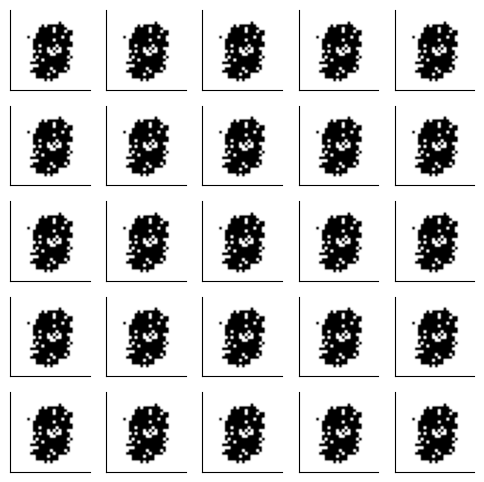

{'discriminator': 5.984111339785159e-08, 'generator': 16.631576538085938} 6.038316e-08 5.978591e-08 1.0
{'discriminator': 6.802976315611886e-08, 'generator': 16.667465209960938} 5.8290535e-08 5.76814e-08 1.0
{'discriminator': 5.5737444881742704e-08, 'generator': 16.702613830566406} 5.6310288e-08 5.5688762e-08 1.0
{'discriminator': 5.382760548400256e-08, 'generator': 16.73748016357422} 5.4416514e-08 5.3781175e-08 1.0
{'discriminator': 5.2022649299487966e-08, 'generator': 16.77183723449707} 5.2612197e-08 5.1964292e-08 1.0
{'discriminator': 5.0274397978000707e-08, 'generator': 16.805770874023438} 5.0894595e-08 5.0232362e-08 1.0


KeyboardInterrupt: 

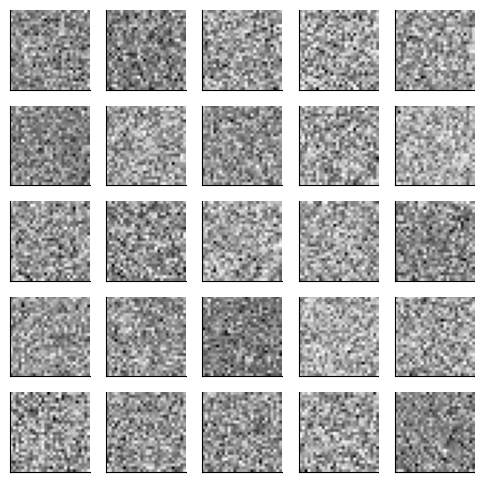

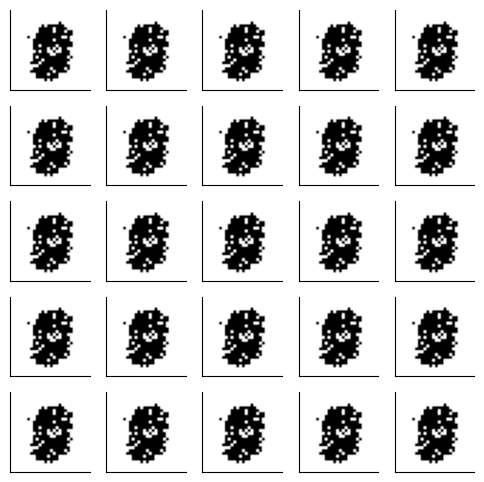

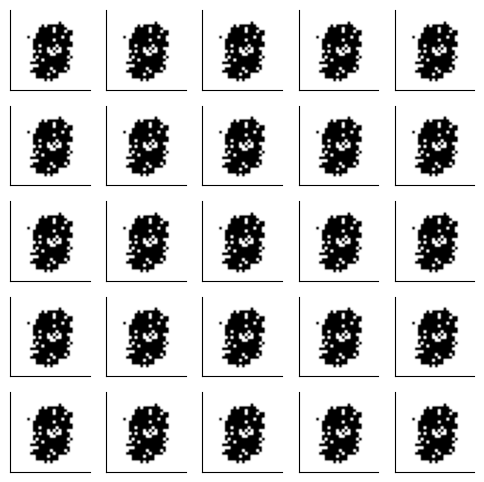

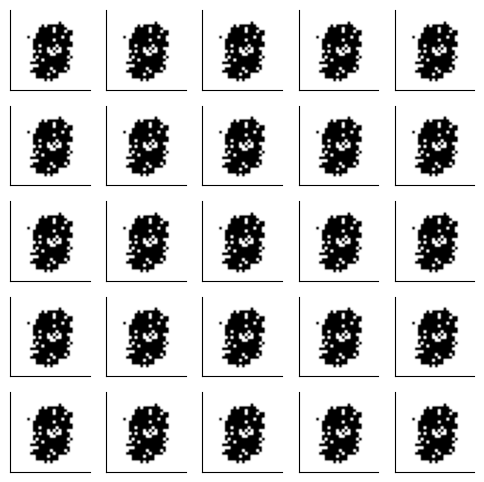

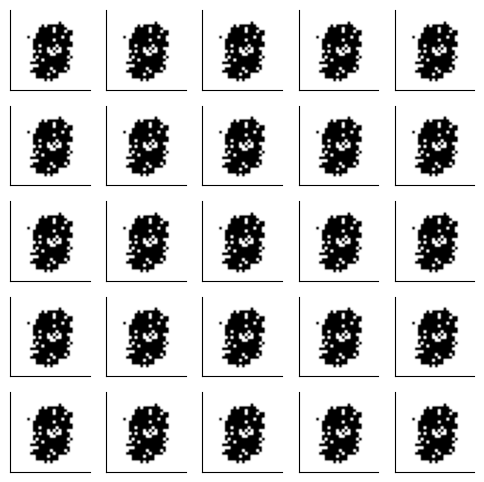

In [198]:
import jax.numpy as np


d_loss_bm_dt = F(discriminator_loss_z).vmap((None, 0, 0), 0).f(_, X_test, get_noise_batch(n_samples_test)) >> mean


for i in range(50000):
    key = next(key_gen)
    data = sample(batch_size)
    xp = generator_b(W['generator'], z)
    W['discriminator'], opt_states['discriminator'] = update_d(W['discriminator'], data, xp, opt_states['discriminator'])
    z = get_noise_batch(batch_size)
    W, opt_states, losses = update(W, data, z, opt_states)

    z = get_noise_batch(batch_size)
    if i % 20 == 0:
        acc = discriminator_accuracy_b(W['discriminator'], xp, data)
        print({k: v.item() for k, v in losses.items()}, d_loss_bm_dt(W), acc[0].mean(), acc[1].mean())#, discriminator_accuracy_b(W['discriminator'], generator_b(W['generator'], z), X_test[:batch_size, :]))
    if i % 500 == 0:
        # plt, __, __ = visualize_matrix(data[image_id, :].reshape(28, 28), dpi=100)
        # display(plt)

        #outs = generator_b(W['generator'], z)
        image_id = math.ceil(random.uniform(0, 1) * n_samples)
        show_samples(xp)

print(d_loss_bm_dt(W))
